# Your first embedding

## Exercise objectives:
- Run your first RNN for NLP
- Get a first taste of what an embedding is

<hr>
<hr>

Words are not something you can easily feed to a Neural Network. For this reason, we have to convert them to something more meaningful. 

And this is exactly what _Embeddings_ are for! They map any word onto a vectorial representation (this a fancy way that to each word corresponds a vector ;) ). For instance, the word `dog` can be represented by the vector $(w_1, w_2, ..., w_n)$ in the embedding space, and we will learn the weights $(w_k)_k$.

So let's just do it.


# The data


❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that a too large number of sentences will make your compute slow down, or even freeze - your RAM can even overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy. 

In [1]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2022-05-20 11:40:36.715522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Now that you have loaded the data, let's look what is inside !

❓ **Question** ❓ You can play with the data here. In particular, `X_train` and `X_test` are lists of sentences. Let's print some of them, with their respective label stored in `y_train` and `y_test`.

In [2]:
len(X_train), len(y_train), len(X_test), len(y_test)


(2500, 2500, 2500, 2500)

**LABELS**, the task corresponds to a binary classification problem:
- label 0 corresponds to a negative movie review
- label 1 corresponds to a positive movie review

**INPUTS** : The data have been partially cleaned ! So you don't have to worry about it in this exercise. But don't forget this step in real-life challenges. 

Remember that words are not computer-compatible materials? You have to tokenize them!

❓ **Question** ❓ Run the following cell to tokenize your sentences

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionnary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set !
# This tokenization also lower your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

❓ **Question** ❓ Print some of the tokenized sentences to be sure you got what you expected

In [4]:
X_train_token[1]

[9,
 25,
 76,
 572,
 5,
 730,
 1945,
 296,
 100,
 17,
 11,
 6,
 625,
 662,
 5,
 2,
 1835,
 4,
 190,
 555,
 61,
 1170,
 115,
 2531,
 3,
 2896,
 20,
 1,
 9585,
 3,
 264,
 40,
 5424,
 2,
 187,
 200,
 20,
 11,
 3435,
 9,
 1387,
 1945,
 80,
 1,
 19,
 13,
 1601,
 1,
 103,
 1056,
 13,
 2090,
 1646,
 515,
 3,
 319,
 190,
 443,
 5,
 531,
 17,
 16,
 53,
 1878,
 4,
 46,
 13,
 4507,
 94,
 39,
 135,
 9,
 929,
 9,
 195,
 25,
 1007,
 170,
 4,
 1,
 19,
 17,
 9,
 262,
 1,
 2532,
 4,
 10,
 3,
 273,
 40,
 443,
 5,
 531,
 4,
 96,
 181,
 9586,
 213,
 99,
 142,
 4508,
 15,
 240,
 298,
 9,
 2897,
 401,
 11,
 19,
 30,
 29]

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
❓ **Question** ❓ Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [5]:
vocab_size = len(tokenizer.word_index)
vocab_size

30419

Your `X_train_token` and `X_test_token` contain sequences of different lengths.

<img src="padding.png" alt='Word2Vec' width="700px" />

However, a neural network has to have a tensor as input. For this reason, you have to pad your data.

❓ **Question** ❓  Pad your data with the `pad_sequences` function (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)). Do not forget about the `dtype` and `padding` keywords (but do not use `maxlen` here).

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=150)


# The RNN

Let's now feed this data to a Recurrent Neural Network.

❓ **Question** ❓ Write a model that has:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAVE TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

<details>
    <summary>💡 Hint</summary>

`input_dim` should equal size of vocabulary + 1

</details>

Compile it with the appropriate arguments

In [7]:
from tensorflow.keras import layers, Sequential

# Size of your embedding space = size of the vector representing each word
embedding_size = vocab_size

model = Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size+1, 
    output_dim=30, # 100
    mask_zero=True, # Built-in masking layer :)
))


In [8]:
model.add(layers.LSTM(20))
model.add(layers.Dense(1, activation="sigmoid"))


❓ **Question** ❓ Look at the number of parameters in your RNN. 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 30)          912600    
                                                                 
 lstm (LSTM)                 (None, 20)                4080      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 916,701
Trainable params: 916,701
Non-trainable params: 0
_________________________________________________________________


❓ **Question** ❓ Check that the number of parameters in your embedding layer is equal to the number of words in your vocabulary, times the dimension of your embedding.

In [10]:
print(f'Expected number of parameters: {(vocab_size+1) * embedding_size}')

Expected number of parameters: 925345980


❓ **Question** ❓ Start fitting your model with 20 epochs, with an early stopping criterion whose patience is equal to 4.

⚠️ **Warning** ⚠️ You might see that it takes a lof ot time! 

**So stop it after a couple of iterations!**

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience= 4)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train_pad, y_train, 
          epochs=20, batch_size=32, 
          verbose=1, callbacks=[es]
         )

Epoch 1/20
79/79 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.5888WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 11s 81ms/step - loss: 0.6775 - accuracy: 0.5888
Epoch 2/20
79/79 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7928WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 6s 78ms/step - loss: 0.4947 - accuracy: 0.7928
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.9036WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 6s 77ms/step - loss: 0.2940 - accuracy: 0.9036
Epoch 4/20
79/79 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9552WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 6s 74ms/step - loss: 0.1652 - accuracy: 0.9552
Epoch 5/20
79/79 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9776WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 6s 81ms/step - loss: 0.0915 - accuracy: 0.9776
Epoch 6/20
79/79 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9908WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 7s 84ms/step - loss: 0.0487 - accuracy: 0.9908
Epoch 7/20
79/79 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9944WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


79/79 [==============================] - 6s 77ms/step - loss: 0.0248 - accuracy: 0.9944
Epoch 8/20
 3/79 [>.............................] - ETA: 6s - loss: 0.0091 - accuracy: 1.0000

KeyboardInterrupt: 

Let's not waste to much time just staring at our screen or taking coffees. It is too early to start having breaks ;)

❓ **Question** ❓ We will reduce the computational time. To do start, let's first look at how many words there are in the different sentences of your train set (Just run the following cell).

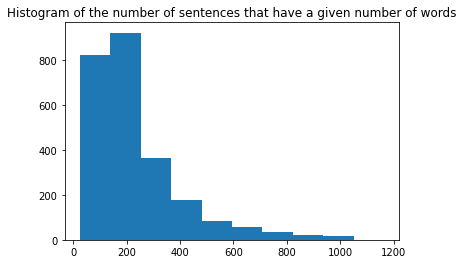

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train)


You will probably see that 90 to 95% of your sentences have less than 300 words. And very few have more than 1000.

However, as you didn't use `maxlen` in your padding above, your input tensor has a dimension equal to the length of the sentence that has the maximum number of words.

Now, let's look at how it affects the padding : 


<img src="tensor_size.png" alt='Word2Vec' width="700px" />

Because of a very few number of sentences, one dimension of your tensor is equal to something like 1000. And most of the sentences that have 200 words have just padded values that are useless.

So your tensor is mostly useless information. But which still takes time to train.

But what if you pad the data to a maximum length (`maxlen`) of say 200 (words)?
- First, that would increase the convergence and you would not need to stare at your screen while waiting for the algorithm to converge
- But in essence, do you really lose that much information? Do you think that you often need more than 200 words (up to 1000) to tell wheter or not a sentence is positive of negative?

❓ **Question** ❓ For all these reasons, come back to your padding and use the `maxlen` keywords and rerun the model !  See how faster it goes now - without hurting the performances ;)

In [ ]:
# YOUR CODE HERE